## Preprocessing - Reweighing -  Adult Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import pandas as pd
from src.data_loading import load_adult_race, load_adult_sex
from src.modeling import reweighing_train_and_predict
from src.metrics import compute_metrics, compare_viz_metrics_2x3, save_agg_metrics, save_raw_metrics
from sklearn.model_selection import StratifiedShuffleSplit

/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

## Build up the function using sex

In [2]:
import pandas as pd
from aif360.algorithms.preprocessing import Reweighing
from src.modeling import get_default_model_pipeline

ds, df = load_adult_sex()
protected         = 'sex'
privileged_value   = 1.0
unprivileged_value = 0.0

feature_cols = [c for c in df.columns if c not in (protected, 'label', 'sex', 'fnlwgt')]

sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)
results = []

for train_idx, test_idx in sss.split(df, df['label']):
    train_bld = ds.subset(train_idx)
    test_bld  = ds.subset(test_idx)

    # Fit & apply REWEIGHING on the training split only
    rw = Reweighing(
        unprivileged_groups=[{protected: unprivileged_value}],
        privileged_groups=[{protected:   privileged_value}]
    )
    rw.fit(train_bld)
    train_transf = rw.transform(train_bld)

    X_tr = train_transf.features
    y_tr = train_transf.labels.ravel()
    w_tr = train_transf.instance_weights.ravel()

    X_te = test_bld.features
    y_te = test_bld.labels.ravel()

    # Train with sample_weight = fnlwgt * reweigh_factor (for adult dataset)
    pipe = get_default_model_pipeline()
    pipe.fit(X_tr, y_tr, clf__sample_weight=w_tr)

    y_pred = pipe.predict(X_te)
    test_df = df.iloc[test_idx]
    
    m = compute_metrics(
        test_df, y_te, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

adult_sex_metrics = pd.DataFrame(results)
adult_sex_metrics_agg = adult_sex_metrics.agg(['mean', 'std'])

In [3]:
adult_sex_metrics_agg

,accuracy,f1_score,SPD,DI,EOD,AOD
mean,0.845065,0.638245,-0.089908,0.589545,0.137647,0.060430
std,0.002639,0.005547,0.008698,0.034020,0.025841,0.014497


## Sex

In [4]:

protected         = 'sex'
privileged_value   = 1.0
unprivileged_value = 0.0

ad, df = load_adult_sex()
feature_cols = [c for c in df.columns if c not in (protected, 'label', 'sex', 'fnlwgt')]

# 1) Set up 25-fold stratified CV
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)
results = []

for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = reweighing_train_and_predict(
        ad, df,
        train_idx, test_idx,
        protected, privileged_value, unprivileged_value
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

adult_sex_metrics = pd.DataFrame(results)
adult_sex_metrics_agg = adult_sex_metrics.agg(['mean', 'std'])

In [5]:
adult_sex_metrics_agg

,accuracy,f1_score,SPD,DI,EOD,AOD
mean,0.845065,0.638245,-0.089908,0.589545,0.137647,0.060430
std,0.002639,0.005547,0.008698,0.034020,0.025841,0.014497


## Race

In [6]:
# 1) Retrieve data
protected = 'race'
privileged_value   = 1.0
unprivileged_value = 0.0

ad, df = load_adult_race()
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = reweighing_train_and_predict(
        ad, df,
        train_idx, test_idx,
        protected, privileged_value, unprivileged_value
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
adult_race_metrics = pd.DataFrame(results)
adult_race_metrics_agg = adult_race_metrics.agg(['mean', 'std'])

In [7]:
adult_race_metrics_agg

,accuracy,f1_score,SPD,DI,EOD,AOD
mean,0.850282,0.658243,-0.048371,0.765315,0.055862,0.025568
std,0.002672,0.006229,0.008595,0.038734,0.031349,0.015739


---------------------------------
## compare with baseline, create plots

In [8]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/adult_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/adult_sex_metrics_agg.csv', index_col=0)

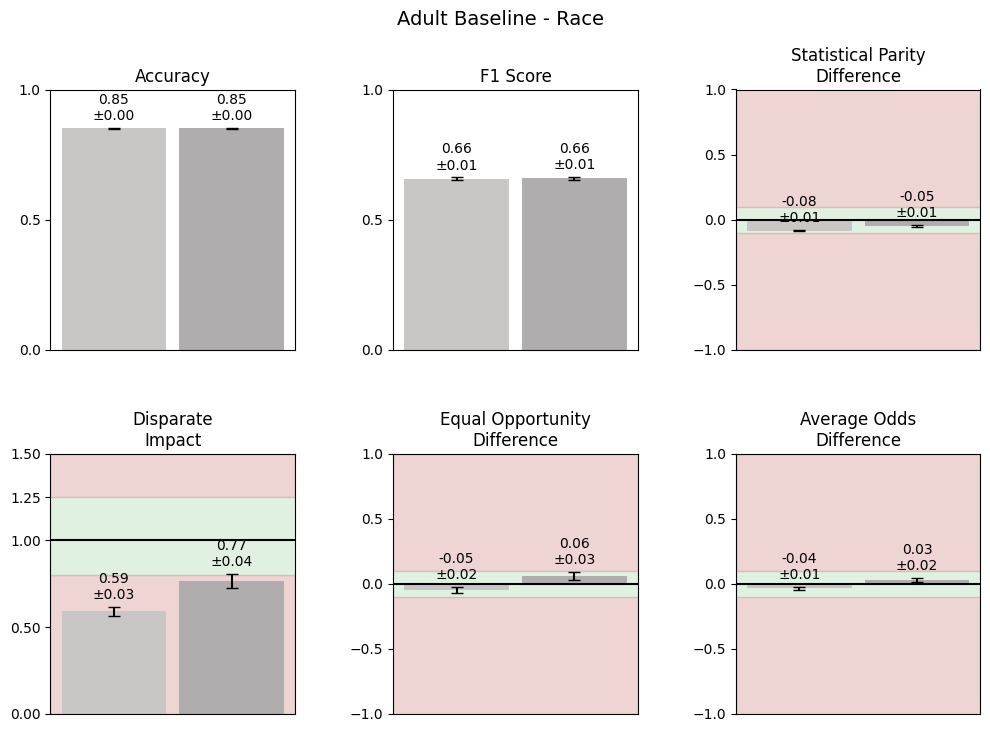

In [9]:
compare_viz_metrics_2x3(baseline_race_agg, adult_race_metrics_agg, 'Baseline', 'Race', 'Adult Baseline - Race')

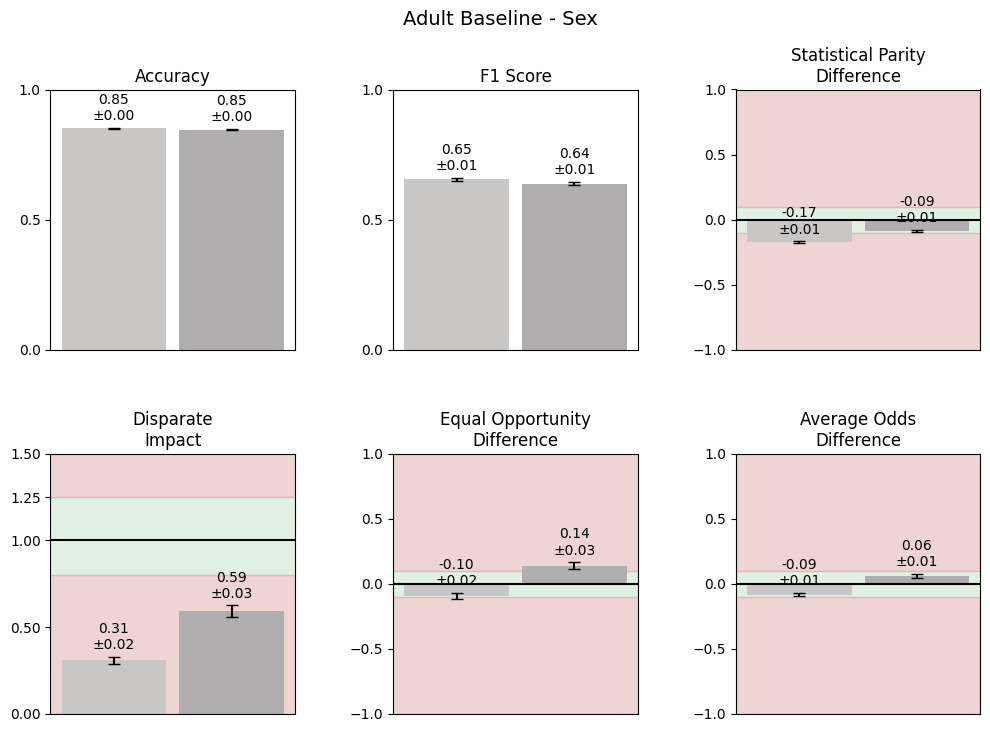

In [10]:
compare_viz_metrics_2x3(baseline_sex_agg, adult_sex_metrics_agg, 'Baseline', 'Race', 'Adult Baseline - Sex')

In [11]:
save_agg_metrics('adult', 'reweighing', adult_race_metrics_agg, adult_sex_metrics_agg)
save_raw_metrics('adult', 'reweighing', adult_race_metrics, adult_sex_metrics)